### Train

In [1]:
import pandas as pd
import numpy as np

In [2]:
from utils.stock_data import StockData
from utils.format_data import generate_target_context_idx_pairs

PERIODS = [1]
TRAIN_PCT = 1
CONTEXT_SIZE = 32

tgt_context_sets = []
for period in PERIODS:
    print(f"Running for period {period}")
    data = StockData(
        daily_returns_path="data/returns_df_528_nse.csv",
        extras_path="data/nse_historical_stocks.csv"
    )
    data.change_returns_period(period)
    data.train_test_split(TRAIN_PCT)

    tgt_context_sets += generate_target_context_idx_pairs(
        data.train_returns_df,
        context_size=CONTEXT_SIZE,
        verbose=True,
        iqr_noise_reduction=True,
    )
    print("="*20)
print(f"Total number of target context sets: {len(tgt_context_sets)}")

Running for period 1
No change made because period entered is 1


100%|██████████| 809/809 [00:01<00:00, 723.19it/s] 

Total number of target context sets: 232470


In [3]:
data

StockData(
    directory=data/returns_df_528_nse.csv,
    num_stocks=809,
    num_sectors=12,
    period=1
)

In [4]:
ticker = "HDFCBANK.NS"
i = data.ticker2idx[ticker]
temp = np.array([xi[1] for xi in tgt_context_sets if xi[0] == i]).flatten()
print(
    f"The most commonly co-occurring stocks with {ticker} are: {[data.idx2ticker[xi] for xi in pd.Series(temp).value_counts().index][:5]}"
)

The most commonly co-occurring stocks with HDFCBANK.NS are: ['SIEMENS.NS', 'VESUVIUS.NS', 'OCCL.NS', 'GARFIBRES.NS', 'LALPATHLAB.NS']


In [11]:
from utils.model import NSE2Vec

EMBEDDING_DIM = 128
model = NSE2Vec(
    n_time_series=len(data.tickers), embedding_dim=EMBEDDING_DIM
)

model

NSE2Vec(
  (embeddings): Embedding(809, 128)
)

In [12]:
from utils.evaluate import evaluate_embeddings
from utils.train import train

EPOCHS = 5

model, losses = train(
    n_time_series=len(data.tickers),
    tgt_context_sets=tgt_context_sets,
    model=model,
    epochs=EPOCHS,
    batch_size=128,
    early_stopping=False,
    device="mps",
    learning_rate = 1e-3,
    # embedding_dim=EMBEDDING_DIM,
    verbose=True,
    sectors=data.sectors
)

Training embeddings...


 20%|██        | 1/5 [00:16<01:06, 16.68s/it]

All labels in y_pred?: True
Precision Score: 0.7
Recall Score: 0.66
F1 Score: 0.67
Accuracy Score: 0.66
Accuracy Score Top-3: 0.78


 40%|████      | 2/5 [00:33<00:49, 16.61s/it]

All labels in y_pred?: True
Precision Score: 0.72
Recall Score: 0.65
F1 Score: 0.67
Accuracy Score: 0.65
Accuracy Score Top-3: 0.77


 60%|██████    | 3/5 [00:50<00:33, 16.73s/it]

All labels in y_pred?: True
Precision Score: 0.67
Recall Score: 0.63
F1 Score: 0.65
Accuracy Score: 0.63
Accuracy Score Top-3: 0.78


 80%|████████  | 4/5 [01:06<00:16, 16.66s/it]

All labels in y_pred?: True
Precision Score: 0.66
Recall Score: 0.63
F1 Score: 0.63
Accuracy Score: 0.63
Accuracy Score Top-3: 0.8


100%|██████████| 5/5 [01:23<00:00, 16.76s/it]

All labels in y_pred?: True
Precision Score: 0.62
Recall Score: 0.62
F1 Score: 0.61
Accuracy Score: 0.62
Accuracy Score Top-3: 0.76


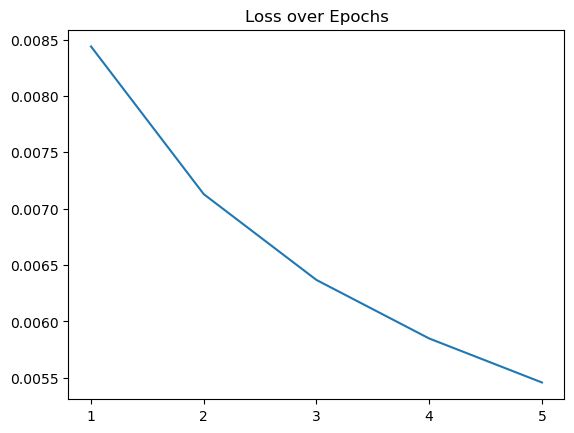

In [9]:
import matplotlib.pyplot as plt

sub_losses = losses[:]

plt.plot(range(1, len(sub_losses)+1), sub_losses)
plt.title("Loss over Epochs")
plt.xticks(range(1, len(sub_losses)+1, max(1, len(sub_losses)//10)))
plt.show()

In [39]:
# model.save_model("nse_n_bse_1.pt")

### Evaluate

In [16]:
model = NSE2Vec(n_time_series=len(data.tickers), embedding_dim=128).load_model("nse2vec.pt")

In [19]:
evaluate_embeddings(model.embeddings.weight.detach().cpu().numpy(), sectors=data.sectors, top_k_accuracy=True, smote=True, n_splits=5)

All labels in y_pred?: True
Precision Score: 0.64
Recall Score: 0.64
F1 Score: 0.64
Accuracy Score: 0.64
Accuracy Score Top-3: 0.79


#### Results
| Data | Train Epochs | Accuracy | Accuracy (top 3) |
| --- | --- | --- | --- |
| NSE+BSE | 10 | 0.64 | 0.79 |
| NSE | 10 | 0.65 | 0.81 |

In [22]:
from utils.visualize import visualize_embeddings

visualize_embeddings(
    embedding_matrix=model.embeddings.weight.detach().cpu().numpy(),
    tickers=data.tickers,
    industries=data.industries,
    sectors=data.sectors,
    names=data.tickers,
    dimensions=2,
    reduced=True,
    method="PCA",
    return_df=False,
    rand_state=None,
)